In [3]:
CONFIG_PATH = "configs/small_sample_sub_minority.yml"

In [1]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
from model import get_best_model, TransformerVoter
from train import evaluate_model, train_model
import copy

为了使用邮件提醒功能，请设置环境变量MY_QQ_EMAIL（QQ邮箱地址）与MY_QQ_EMAIL_PWD（QQ邮箱授权码）
------------------ 2022-08-06 03:54:30 ------------------


In [5]:
config = get_config(CONFIG_PATH, "_curation", print_config = False)
debug(device = config["device"])
use_voted_users_feature = config["use_voted_users_feature"]
use_voted_users_feature = False # TODO:
if use_voted_users_feature:
    debug("Use peer votes as model input feature")
else:
    debug("Finetune the model using peer votes")

GPU ready...
Smart using cuda:0
------------------ 2022-08-06 03:55:07 ------------------
DEBUG: 1 vars: ['device'], at <ipython-input-5-fcca25d97494>:2 <module>
0 / 2.  device str len 6: cuda:0
------------------ 2022-08-06 03:55:07 ------------------
------------------ 2022-08-06 03:55:07 ------------------
DEBUG: at <ipython-input-5-fcca25d97494>:8 <module>
Finetune the model using peer votes
------------------ 2022-08-06 03:55:07 ------------------


In [6]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)

------------------ 2022-08-06 03:55:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:345 get_model_input
Loading prepared data...
------------------ 2022-08-06 03:55:11 ------------------


In [7]:
model, _ = get_best_model(config, categorical_features, string_features, original_feature_map)

------------------ 2022-08-06 03:55:14 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 3.  original_token_num num val: 30522
------------------ 2022-08-06 03:55:14 ------------------
------------------ 2022-08-06 03:55:14 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 4.  latest_token_num num val: 153833
------------------ 2022-08-06 03:55:14 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-08-06 03:55:16 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:110 load_model
Loading best model...
------------------ 2022-08-06 03:55:16 ------------------


In [8]:
print(model.device)
test_data.iloc[:2]
# !nvidia-smi

cuda:0


,SUBMISSION_ID,SUBREDDIT,CREATED_TIME,USERNAME,VOTE,TITLE,AUTHOR,#_COMMENTS,NSFW,SCORE,UPVOTED_%,LINK,SUBMISSION_TEXT,UPVOTED_USERS,DOWNVOTED_USERS
0,t3_foozz0,r/metacanada,Wed Mar 25 2020,20437,1.0,Chris Cuomo mocking Trump’s “Chinese Virus” is...,3217,14,false,60,0.91,https://www.reddit.com/r/metacanada/comments/f...,Chris Cuomo mocking Trump’s “Chinese Virus” is...,[],[]
1,t3_faxmbr,r/curlyhair,Fri Feb 28 2020,6637,1.0,If you ever doubted the CG method...,89419,19,false,364,1.00,https://www.reddit.com/r/curlyhair/comments/fa...,If you ever doubted the CG method...,[],[]


In [9]:
def count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data):
    peer_votes_num_acc_df.loc[peer_vote_num, "Total"] += 1
    pred_target_vote = int(pred_target_vote_score >= 0.5)
    if pred_target_vote == target_vote:
        peer_votes_num_acc_df.loc[peer_vote_num, "Acc"] += 1
        peer_votes_num_acc_df.loc[peer_vote_num, "Confidence"] += abs(pred_target_vote_score - 0.5)
    if peer_vote_num > 0:
        majority_vote = -1
        if sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num > 0.5:
            majority_vote = 1
        elif sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num < 0.5:
            majority_vote = 0
        if pred_target_vote == majority_vote:
            peer_votes_num_acc_df.loc[peer_vote_num, "Same as majority"] += 1


def pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data):
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    upvoted_users, downvoted_users = [], []
    for new_user_i in range(-1, len(all_peer_users)):
        peer_vote_num = new_user_i + 1
        if new_user_i >= 0:
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
        target_vote_data.at[0, "UPVOTED_USERS"] = upvoted_users
        target_vote_data.at[0, "DOWNVOTED_USERS"] = downvoted_users
        pred_target_vote_score = evaluate_model(config, model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
        count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1):
    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, data=peer_votes_data, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, step_generator=True, n_step_per_sample=n_step_per_sample, extra_input = extra_input)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1
            pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1): # conbination of the upper two
    pd.options.mode.chained_assignment = None
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    target_vote_model_input = {column: target_vote_data[column] for column in target_vote_data}

    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    upvoted_users, downvoted_users = [], []
    target_vote_model_input["UPVOTED_USERS"] = [upvoted_users]
    target_vote_model_input["DOWNVOTED_USERS"] = [downvoted_users]
    pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, ret="prediction", disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        peer_votes_model_input = {column: peer_votes_data[column] for column in peer_votes_data}
        # construct train model peer_votes_model_input
        peer_votes_model_input["UPVOTED_USERS"].loc[0] = upvoted_users
        peer_votes_model_input["DOWNVOTED_USERS"].loc[0] = downvoted_users
        for user_i in range(1, len(all_peer_users)):
            new_user = all_peer_users[user_i - 1] # add last user (user_i - 1) to the peer votes for user_i
            new_vote = all_peer_votes[user_i - 1]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
            peer_votes_model_input["UPVOTED_USERS"].loc[user_i] = upvoted_users
            peer_votes_model_input["DOWNVOTED_USERS"].loc[user_i] = downvoted_users
        
        # finetune the model
        upvoted_users, downvoted_users = [], []
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, x=peer_votes_model_input, y=peer_votes_data[target].values, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, max_voted_users=max_voted_users, step_generator=True, n_step_per_sample=n_step_per_sample)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1

            # add peer votes to model input features
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
            target_vote_model_input["UPVOTED_USERS"] = [upvoted_users]
            target_vote_model_input["DOWNVOTED_USERS"] = [downvoted_users]

            pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, ret="prediction", disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

In [10]:
n_step_per_sample = 1
if not use_voted_users_feature:
    model.optim = torch.optim.Adam(model.parameters(), lr = 0.5 * config["learning_rate"]) # 2 还不错，5不行
    n_step_per_sample = 1

In [11]:
from tqdm import tqdm

test_submissions = list(set(test_data["SUBMISSION_ID"]))
max_voted_users = 1000
peer_votes_num_acc_df = pd.DataFrame(np.zeros((max_voted_users + 1,4)), columns=['Acc', 'Confidence', 'Total', "Same as majority"])
model.to(model.device)
# test_data["UPVOTED_USERS"] = test_data["UPVOTED_USERS"].astype('object')
# test_data["DOWNVOTED_USERS"] = test_data["DOWNVOTED_USERS"].astype('object')
for submission_id in tqdm(test_submissions[:]):
    submission_votes_data = test_data[test_data["SUBMISSION_ID"] == submission_id]
    submission_votes_data = submission_votes_data.sample(frac=1).reset_index(drop=True) # shuffle
    target_vote_data = submission_votes_data.iloc[-1:].reset_index(drop=True)
    target_vote = int(target_vote_data["VOTE"])
    peer_votes_data = submission_votes_data.iloc[:-1]
    if use_voted_users_feature:
        pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data)
        # pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
    else:
        pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)    

100%|██████████| 30675/30675 [4:29:38<00:00,  1.90it/s]  


In [12]:
peer_votes_num_acc_df = peer_votes_num_acc_df[peer_votes_num_acc_df["Total"] > 0]
peer_votes_num_acc_df["Acc rate"] = peer_votes_num_acc_df["Acc"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Avg confidence"] = peer_votes_num_acc_df["Confidence"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Same as majority rate"] = peer_votes_num_acc_df["Same as majority"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Total scaled"] = peer_votes_num_acc_df["Total"]/max(peer_votes_num_acc_df["Total"])
peer_votes_num_acc_df

,Acc,Confidence,Total,Same as majority,Acc rate,Avg confidence,Same as majority rate,Total scaled
0,24742.0,6259.301696,30675.0,0.0,0.806585,0.204052,0.000000,1.000000
1,4301.0,1202.194944,4985.0,4177.0,0.862788,0.241162,0.837914,0.162510
2,1976.0,636.121206,2257.0,1688.0,0.875498,0.281844,0.747895,0.073578
3,1181.0,421.774220,1346.0,1216.0,0.877415,0.313354,0.903418,0.043879
4,768.0,297.994298,879.0,767.0,0.873720,0.339015,0.872582,0.028655
...,...,...,...,...,...,...,...,...
80,1.0,0.493556,1.0,1.0,1.000000,0.493556,1.000000,0.000033
81,1.0,0.493743,1.0,1.0,1.000000,0.493743,1.000000,0.000033
82,1.0,0.493915,1.0,1.0,1.000000,0.493915,1.000000,0.000033
83,1.0,0.494493,1.0,1.0,1.000000,0.494493,1.000000,0.000033


------------------ 2022-08-06 08:25:00 ------------------
DEBUG: at <ipython-input-13-3153bdc667b0>:6 <module>
Acc rate
------------------ 2022-08-06 08:25:00 ------------------


<AxesSubplot:ylabel='Avg confidence'>

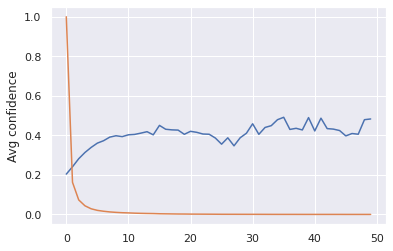

In [13]:
def convert_df_to_dict(df: pd.DataFrame):
    return {x:list(df[x]) for x in df}
import seaborn as sns

peer_votes_num_acc_df_part = peer_votes_num_acc_df.iloc[:50]
debug("Acc rate")
sns.set_theme()
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Avg confidence')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
# ax.set_ylim(ymax=1)

<AxesSubplot:ylabel='Acc rate'>

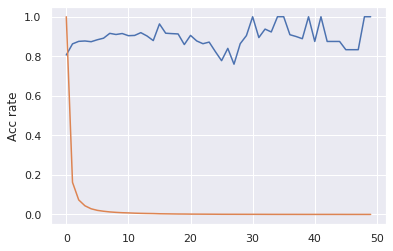

In [14]:
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Acc rate')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')

------------------ 2022-08-06 08:25:00 ------------------
DEBUG: at <ipython-input-15-256f6a6658fb>:1 <module>
Same as majority rate
------------------ 2022-08-06 08:25:00 ------------------


<AxesSubplot:ylabel='Same as majority rate'>

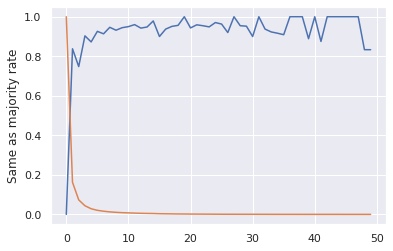

In [15]:
debug("Same as majority rate")
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Same as majority rate')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
